### Generated Image

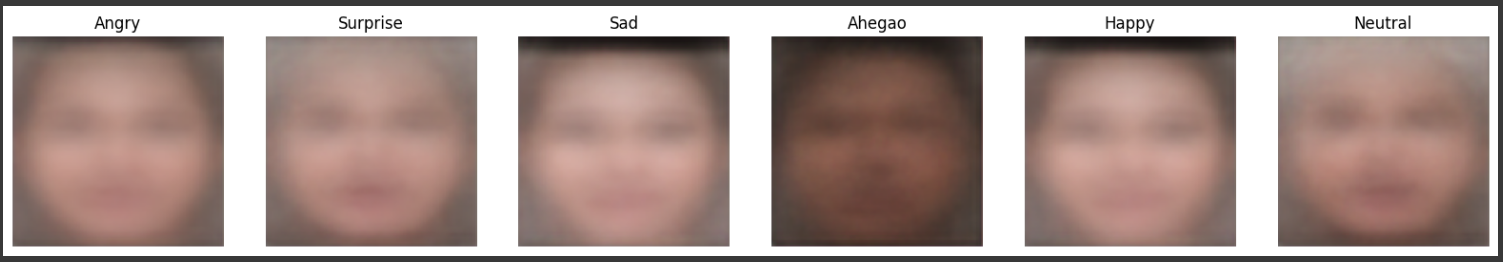

In [40]:
path = '/content/generated_images.png'
Image(path)

### Importing Libraries

In [39]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from scipy.linalg import sqrtm
from numpy import cov, trace, iscomplexobj
from numpy.random import random
from scipy.stats import entropy
from IPython.display import Image

### Mounting the Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Reading the images from the drive

In [3]:
base_dir = '/content/drive/My Drive/dataset'
categories = ['Angry', 'Surprise', 'Sad', 'Ahegao', 'Happy', 'Neutral']

for category in categories:
    print(f'{category}:')
    path = os.path.join(base_dir, category)
    print(os.listdir(path)[:5])  # List first 5 files in each category


Angry:
['cropped_emotions.158016~angry.png', 'cropped_emotions.157963~angry.png', 'b24483d09ed49bcaa6b0e9612bd1bd4b313ab6256695ebb4a770ed98~angry.jpg', '8e2340daa907bf638d4b8cdd7e0be3e7055150e3cb2f4c0ec59b33d5~angry.jpg', 'bf012b12add1c87ae948972971f7c398bd6460a5b9070349e8eabf9f~angry.jpg']
Surprise:
['cropped_emotions.100127~12fffff.png', 'cropped_emotions.100095~12fffff.png', 'cropped_emotions.100214~12fffff.png', 'cropped_emotions.100151~12fffff.png', 'cropped_emotions.100158~12fffff.png']
Sad:
['cropped_emotions.164214.png', '8bbb137335dada8395b68eada658c37a9130beb0678af6afd310d8ed.jpg', '8c3d01094387b431bdc3bf9336dfb6bde2dac6b991e572d8a7e184e3.jpg', 'cropped_emotions.165179.png', 'cropped_emotions.164410.png']
Ahegao:
['cropped_emotions.190045~ahegao.png', 'cropped_emotions.190809~ahegao.png', 'cropped_emotions.190726~ahegao.png', 'cropped_emotions.190326~ahegao.png', 'cropped_emotions.190663~ahegao.png']
Happy:
['cropped_emotions.271917.png', 'cropped_emotions.374462.png', 'cropp

### Displaying images form each folder

Displaying first 5 images from category: Angry


Displaying first 5 images from category: Surprise


Displaying first 5 images from category: Sad


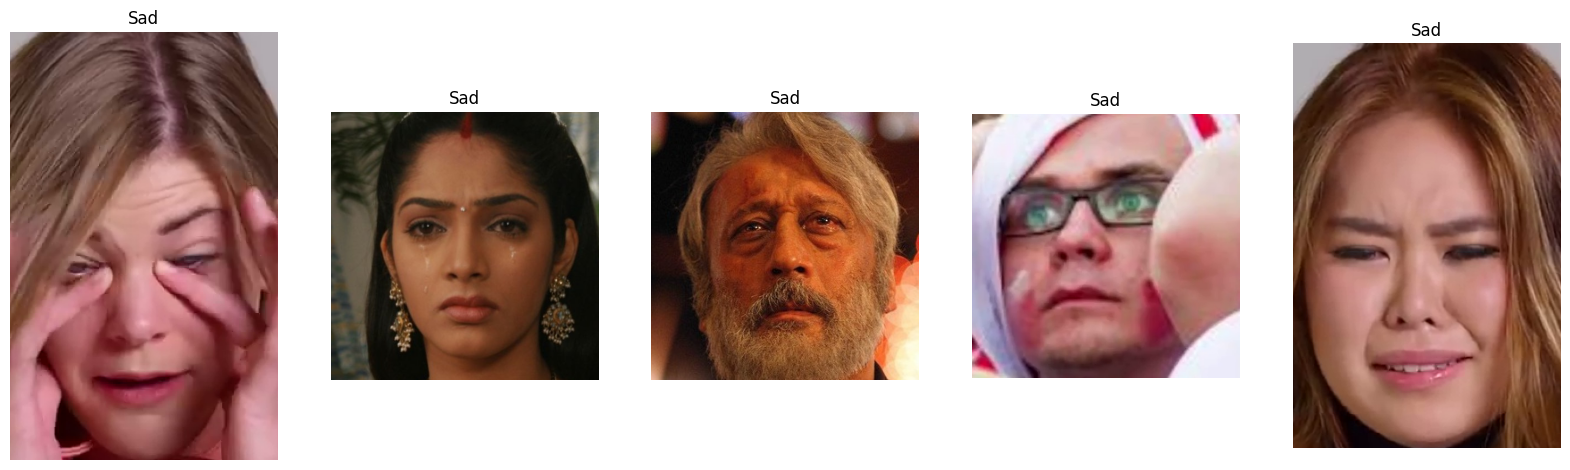

Displaying first 5 images from category: Ahegao


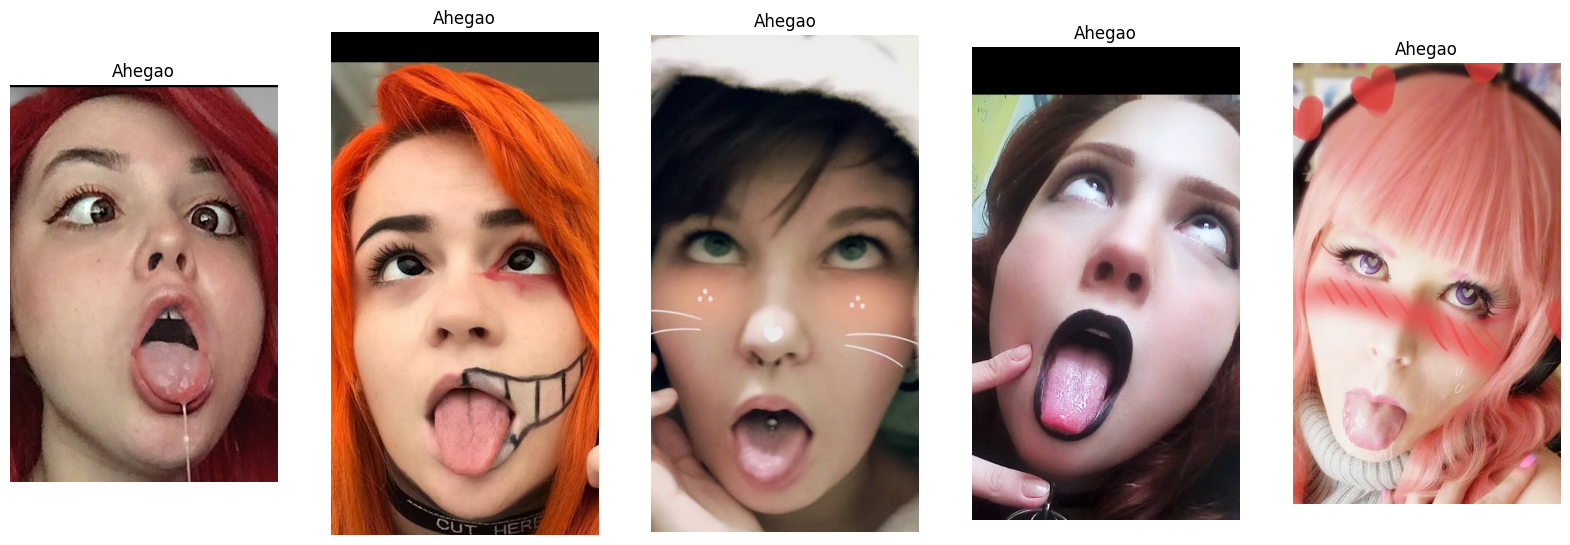

Displaying first 5 images from category: Happy


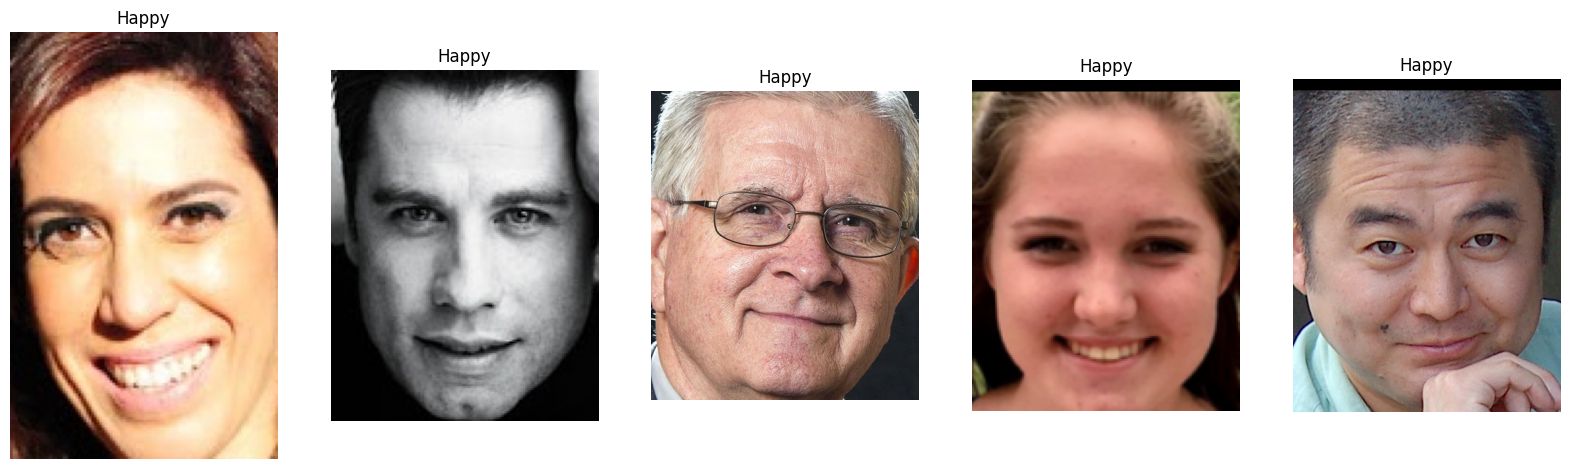

Displaying first 5 images from category: Neutral


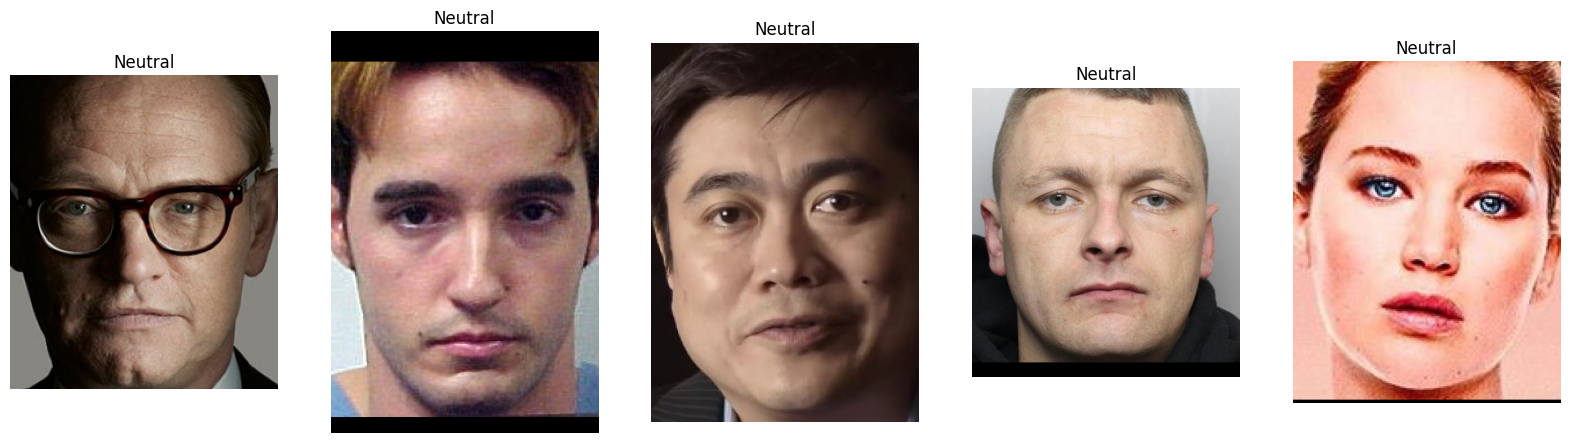

In [4]:
# Function to display images
def display_images(category, image_files):
    plt.figure(figsize=(20, 10))
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(base_dir, category, img_file)
        img = mpimg.imread(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)
    plt.show()

# Iterate through each category and display the first 5 images
for category in categories:
    path = os.path.join(base_dir, category)
    image_files = os.listdir(path)[:5]
    print(f'Displaying first 5 images from category: {category}')
    display_images(category, image_files)

###  Load Images using "ImageDataGenerator" from keras.preprocessing.image

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

image_size = (128, 128)  # Resize images to 128x128

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='input',  # Input because we are using these images for unsupervised learning
    shuffle=True
)


Found 15453 images belonging to 6 classes.


### Creating a subset folder

In [6]:
# Create a new directory for the subset of images
subset_dir = '/content/subset_dataset'
os.makedirs(subset_dir, exist_ok=True)

### Loading sample images

In [7]:
# Copy 100 images from each category to the new directory
for category in categories:
    category_dir = os.path.join(base_dir, category)
    subset_category_dir = os.path.join(subset_dir, category)
    os.makedirs(subset_category_dir, exist_ok=True)

    image_files = os.listdir(category_dir)[:200]
    for img_file in image_files:
        shutil.copy(os.path.join(category_dir, img_file), subset_category_dir)

In [8]:
# Verify the new dataset
for category in categories:
    subset_category_dir = os.path.join(subset_dir, category)
    print(f'{category}: {len(os.listdir(subset_category_dir))} images')

Angry: 200 images
Surprise: 200 images
Sad: 200 images
Ahegao: 200 images
Happy: 200 images
Neutral: 200 images


In [9]:
# Define image size and latent dimension
image_size = (128, 128)
latent_dim = 2

### Loading the sample images

In [10]:
# Data Generator
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    subset_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='input',
    shuffle=True
)


Found 1200 images belonging to 6 classes.


### Building the Variational Autoencoder

#### Encoder

In [11]:
# Encoder
encoder_inputs = tf.keras.Input(shape=(image_size[0], image_size[1], 3))
x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [12]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [13]:
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           18496     ['max_pooling2d[0][0]'] 

#### Decoder

In [14]:
# Decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(32 * 32 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

In [15]:
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 65536)             196608    
                                                                 
 reshape (Reshape)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 64)        36928     
 anspose)                                                        
                                                                 
 up_sampling2d (UpSampling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 64, 64, 32)        1846

In [16]:
# VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae = tf.keras.Model(encoder_inputs, outputs, name='vae')

In [17]:
# VAE loss
reconstruction_loss = tf.keras.losses.binary_crossentropy(K.flatten(encoder_inputs), K.flatten(outputs))
reconstruction_loss *= image_size[0] * image_size[1]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  8408644   ['input_1[0][0]']             
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 128, 128, 3)          252867    ['encoder[0][2]']             
                                                                                                

#### Training

In [18]:
# Training
epochs = 10
vae.fit(train_generator, epochs=epochs)

Epoch 1/10
38/38 [==============================] - 118s 3s/step - loss: 10986.2549
Epoch 2/10
38/38 [==============================] - 111s 3s/step - loss: 10519.9170
Epoch 3/10
38/38 [==============================] - 109s 3s/step - loss: 10208.2949
Epoch 4/10
38/38 [==============================] - 114s 3s/step - loss: 10121.5459
Epoch 5/10
38/38 [==============================] - 110s 3s/step - loss: 10095.8857
Epoch 6/10
38/38 [==============================] - 109s 3s/step - loss: 10088.5928
Epoch 7/10
38/38 [==============================] - 108s 3s/step - loss: 10087.8359
Epoch 8/10
38/38 [==============================] - 111s 3s/step - loss: 10081.9609
Epoch 9/10
38/38 [==============================] - 110s 3s/step - loss: 10087.4785
Epoch 10/10
38/38 [==============================] - 115s 3s/step - loss: 10081.7100


#### Model Evaluation

In [19]:
# Load pretrained InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def calculate_fid(real_images, generated_images):
    # Calculate activations
    act1 = inception_model.predict(real_images)
    act2 = inception_model.predict(generated_images)

    # Calculate mean and covariance
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)

    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    # Calculate sqrt of product between covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check and correct imaginary numbers from sqrtm
    if iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

87910968/87910968 [==============================] - 1s 0us/step


In [20]:
# Function to preprocess images for InceptionV3
def preprocess_images(imgs):
    imgs = tf.image.resize(imgs, (299, 299))
    imgs = preprocess_input(imgs)
    return imgs

Real Images

In [21]:
# Load Real Images
real_datagen = ImageDataGenerator(rescale=1./255)
real_generator = real_datagen.flow_from_directory(
    subset_dir,
    target_size=(299, 299),  # Resize to 299x299 for InceptionV3
    batch_size=600,  # Load all 600 real images (100 per category)
    class_mode=None,
    shuffle=True
)
real_images = next(real_generator)

Found 1200 images belonging to 6 classes.


Generated Images

In [22]:
# Generate Images using VAE
def generate_images(model, latent_dim, num_images):
    z_sample = np.random.normal(size=(num_images, latent_dim))
    generated_images = model.predict(z_sample)
    return generated_images

generated_images = generate_images(decoder, latent_dim, 600)
generated_images_resized = tf.image.resize(generated_images, (299, 299))

19/19 [==============================] - 8s 416ms/step


Preprocess Real and Generated images

In [23]:
# Preprocess images for InceptionV3
real_images_preprocessed = preprocess_input(real_images)
generated_images_preprocessed = preprocess_input(generated_images_resized)

In [24]:
# Calculate FID
fid = calculate_fid(real_images_preprocessed, generated_images_preprocessed)
print('FID:', fid)

19/19 [==============================] - 146s 8s/step
FID: 2.1577537215391715e+57


In [25]:
# Ensure generated images are in the correct format (299x299x3) for InceptionV3
generated_images_resized_inception = np.array(generated_images_resized)

In [26]:
# Ensure images are preprocessed for InceptionV3 model
def preprocess_images(images):
    images = preprocess_input(images)
    return images

In [27]:
# Preprocess generated images
generated_images_preprocessed = preprocess_images(generated_images_resized_inception)

# Predict class probabilities for generated images
preds = inception_model.predict(generated_images_preprocessed)

19/19 [==============================] - 150s 8s/step


In [28]:
def calculate_inception_score(preds, num_splits=10):
    scores = []
    split_size = preds.shape[0] // num_splits

    for i in range(num_splits):
        split_preds = preds[i * split_size:(i + 1) * split_size]
        p_yx = np.mean(split_preds, axis=0)  # Average class probabilities across the split
        scores.append(entropy(p_yx, base=2))  # Compute entropy of the average probabilities

    inception_score = np.exp(np.mean(scores))
    return inception_score

In [29]:
# Calculate Inception Score
inception_score = calculate_inception_score(preds)
print('Inception Score:', inception_score)

Inception Score: 5916.713493241004


In [30]:
print('FID:', fid)

FID: 2.1577537215391715e+57


#### Generate Images

In [31]:
# Define the categories
categories = ['Angry', 'Surprise', 'Sad', 'Ahegao', 'Happy', 'Neutral']

# Generate one image for each category
def generate_images_per_category(model, latent_dim, num_images=1):
    generated_images = []
    for _ in range(num_images * len(categories)):
        z_sample = np.random.normal(size=(1, latent_dim))
        generated_image = model.predict(z_sample)
        generated_images.append(generated_image[0])
    return np.array(generated_images)

In [32]:
# Generate images
generated_images = generate_images_per_category(decoder, latent_dim, num_images=1)


1/1 [==============================] - 0s 45ms/step


In [33]:
# Plot generated images
def plot_generated_images(images, categories):
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(images):
        plt.subplot(1, len(categories), i + 1)
        plt.imshow((img * 255).astype(np.uint8))
        plt.axis('off')
        plt.title(categories[i])
    plt.show()

plot_generated_images(generated_images, categories)

In [34]:
# Define the categories
categories = ['Angry', 'Surprise', 'Sad', 'Ahegao', 'Happy', 'Neutral']

# Function to generate and save faces
def save_generated_faces(model, latent_dim, categories, save_dir='/content/generated_faces'):
    os.makedirs(save_dir, exist_ok=True)
    for i, category in enumerate(categories):
        z_sample = np.random.normal(size=(1, latent_dim))
        generated_image = model.predict(z_sample)
        generated_image = (generated_image[0] * 255).astype(np.uint8)
        plt.imsave(os.path.join(save_dir, f'{category}.png'), generated_image)
save_generated_faces(decoder, latent_dim, categories)

1/1 [==============================] - 0s 47ms/step
